# <b> Table of Content </b>

## <u>Task 1: Data Preparation </u>

- Task 1.1: Import  the  entire  geographical  dataset  and  plot  the  potential  warehouse  locations  across  the test borough. 

- Task 1.2: Identify the neighbourhoods that can be served by a warehouse established at any eligible  location in  the borough,

- Task 1.3: Shortlist of the of the 5 warehouse locations with the highest population coverage and plot their locations in the map.

## <u>Task 2: Expansion Modelling </u>
- Task 2.2: Develop  an  implementation  of  the  above  formulation  using  PuLP, and use it to determine (and  visualise) the locations of the optimal combination of depots.

## <u>Task 3: Selection of Future Stations</u>
- Task 3.1: Develop a facility expansion plan for the duration of the trial period, using a modified version of the Set Covering model that you developed in Task 2.1.
- Task 3.2: Test whether there exists another borough in London that would have resulted in the highest number of total sales over the duration.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import *
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd
from matplotlib import cm
import random
import matplotlib.patches as mpatches

## Task 1: Data Preparation 

### Task 1.1: Import the entire geographical dataset and plot the potential warehouse locations across the test borough.

In [2]:
# Load excel file
excel_df = pd.read_csv('population_and_centroids.csv')

# Extract London Borough Hammersmith and Fulham datase
borough_df = excel_df[excel_df['lsoa_name'].str.contains("Hammersmith and Fulham")]

# Sort by LSOA code
borough_df = borough_df.sort_values(by = ['lsoa_code'], axis=0, ascending=True)

borough_df.head(5)

,Unnamed: 0,lsoa_code,lsoa_name,pop,centroid_id,latitude,longitude
1870,1870,E01001851,Hammersmith and Fulham 010A,1572,21980,51.498875,-0.218701
1871,1871,E01001852,Hammersmith and Fulham 007A,1704,21977,51.501758,-0.216664
1872,1872,E01001853,Hammersmith and Fulham 007B,1446,21978,51.500209,-0.224354
1873,1873,E01001854,Hammersmith and Fulham 007C,1745,21975,51.501431,-0.220509
1874,1874,E01001855,Hammersmith and Fulham 010B,1580,21976,51.499451,-0.213745


In [3]:
# Load Geopandas file
gpd_df = gpd.read_file('LSOA_GreaterLondon.shp')

# Extract London Borough Hammersmith and Fulham datase
ldn_df = gpd_df[gpd_df['lsoa_name'].str.contains("Hammersmith and Fulham")]

# Sort by LSOA code
ldn_df = ldn_df.sort_values(by = ['lsoa_code'], axis=0, ascending=True)

# Rename polygon column
ldn_df.rename_geometry("polygon", inplace = True)

ldn_df.head(5)

,lsoa_code,lsoa_name,polygon
1804,E01001851,Hammersmith and Fulham 010A,"POLYGON ((-0.21734 51.49952, -0.21741 51.49927..."
1805,E01001852,Hammersmith and Fulham 007A,"POLYGON ((-0.21682 51.50423, -0.21531 51.50252..."
1806,E01001853,Hammersmith and Fulham 007B,"POLYGON ((-0.22261 51.50129, -0.22261 51.50100..."
1807,E01001854,Hammersmith and Fulham 007C,"POLYGON ((-0.21998 51.50237, -0.21955 51.50158..."
1808,E01001855,Hammersmith and Fulham 010B,"POLYGON ((-0.21561 51.50119, -0.21501 51.50034..."


In [4]:
# Convert latitude and longitude in excel to GeoSeries and attach to ldn_df
gpd.GeoDataFrame(ldn_df, geometry=gpd.points_from_xy(borough_df.longitude, borough_df.latitude))
ldn_df.head()

,lsoa_code,lsoa_name,polygon,geometry
1804,E01001851,Hammersmith and Fulham 010A,"POLYGON ((-0.21734 51.49952, -0.21741 51.49927...",POINT (-0.21870 51.49888)
1805,E01001852,Hammersmith and Fulham 007A,"POLYGON ((-0.21682 51.50423, -0.21531 51.50252...",POINT (-0.21666 51.50176)
1806,E01001853,Hammersmith and Fulham 007B,"POLYGON ((-0.22261 51.50129, -0.22261 51.50100...",POINT (-0.22435 51.50021)
1807,E01001854,Hammersmith and Fulham 007C,"POLYGON ((-0.21998 51.50237, -0.21955 51.50158...",POINT (-0.22051 51.50143)
1808,E01001855,Hammersmith and Fulham 010B,"POLYGON ((-0.21561 51.50119, -0.21501 51.50034...",POINT (-0.21375 51.49945)


In [5]:
# Append population to ldn_df
ldn_df['population'] = list(borough_df['pop'])
ldn_df.head(5)

,lsoa_code,lsoa_name,polygon,geometry,population
1804,E01001851,Hammersmith and Fulham 010A,"POLYGON ((-0.21734 51.49952, -0.21741 51.49927...",POINT (-0.21870 51.49888),1572
1805,E01001852,Hammersmith and Fulham 007A,"POLYGON ((-0.21682 51.50423, -0.21531 51.50252...",POINT (-0.21666 51.50176),1704
1806,E01001853,Hammersmith and Fulham 007B,"POLYGON ((-0.22261 51.50129, -0.22261 51.50100...",POINT (-0.22435 51.50021),1446
1807,E01001854,Hammersmith and Fulham 007C,"POLYGON ((-0.21998 51.50237, -0.21955 51.50158...",POINT (-0.22051 51.50143),1745
1808,E01001855,Hammersmith and Fulham 010B,"POLYGON ((-0.21561 51.50119, -0.21501 51.50034...",POINT (-0.21375 51.49945),1580


In [6]:
# Obtain unique names for task 3.2
filter_name = []
for names in list(excel_df['lsoa_name']):
    filter_name.append(names[:-5])
filter_name = pd.unique(filter_name)

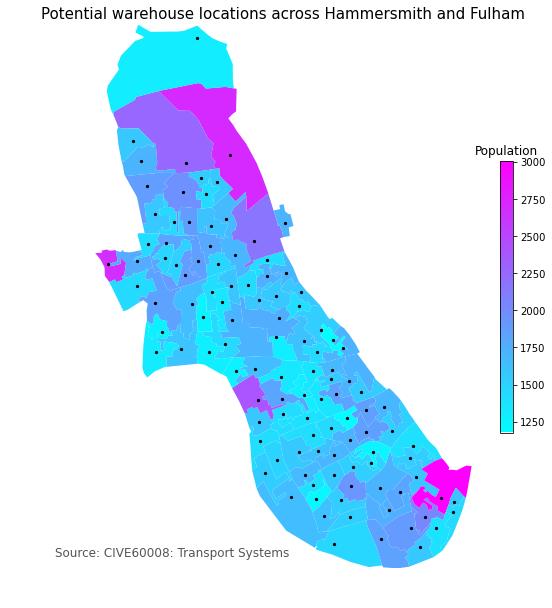

In [7]:
# Create plot and set equal axis
fig, ax = plt.subplots(1, figsize = (10,10))
ax.axes.set_aspect('equal')

# This is ensuring that any MultiPolygons have been separated into normal Polygons.
all_polygons = ldn_df.polygon.explode(index_parts=True)

# Initialise min x and y and max x and y with extreme values.
minx, miny, maxx, maxy = 50000, 50000, -50000, -50000

# Calculate the minimum and maximum longitudes (x), latitudes (y)
minx = min(min(list(map(list, zip(*list(n.exterior.coords))))[0]) for t,n in enumerate(all_polygons))
miny = min(min(list(map(list, zip(*list(n.exterior.coords))))[1]) for t,n in enumerate(all_polygons))
maxx = max(max(list(map(list, zip(*list(n.exterior.coords))))[0]) for t,n in enumerate(all_polygons))
maxy = max(max(list(map(list, zip(*list(n.exterior.coords))))[1]) for t,n in enumerate(all_polygons))

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# add a title
ax.set_title('Potential warehouse locations across Hammersmith and Fulham', fontdict={'fontsize': '15', 'fontweight': '3'})

# Remove the axis for better presentation
ax.axis('off') 

# Annotate and add source
ax.annotate('Source: CIVE60008: Transport Systems',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='#555555')

# Plot using a rainbow colormap
ldn_df.plot(ax=ax,alpha=1, column='population', cmap='cool')

# Plot all the centroids
for v in ldn_df['geometry']:
        ax.scatter(x=v.x, y=v.y, s=5, color='black', marker='o')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='cool', norm=plt.Normalize(vmin=ldn_df.population.min(), vmax=ldn_df.population.max()))# empty array for the data range
cbar = fig.colorbar(sm, shrink=0.5)

# Color bar title
cbar.ax.set_title("Population", size = 12);

### Task 1.2: Identify the neighbourhoods that can be served by a random warehouse established in accordance with the 0.5 km delivery range limitation. 

In [8]:
# Create function to calculate distance

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    """
    
    r_earth = 6365.078
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = r_earth * c
    return km


In [9]:
# Select a random main centroid from Hammersmith and Fulham Borough
for geometry in ldn_df['geometry'][ldn_df.lsoa_code == 'E01001890']: # Insert LSOA code wanted
    centroid_main = {'main': geometry}

# Create a dictionary of all centroids
centroid_set = dict(zip(list('pt'+ str(i) for i in ldn_df['lsoa_code']), ldn_df['geometry']))

In [10]:
# Calculate the distance between the random main centroid and all centroids
dist_dict = {}
for k1, v1 in centroid_main.items():
    for k2, v2 in centroid_set.items():
        dist_dict[(k1,k2)] = haversine_np(v1.x,v1.y,v2.x,v2.y)

In [11]:
# Create a coverage matrix of the centroids that are 0.5 km away from the main centroids
max_distance = 0.5
coverage_matrix = {}
for k1, v1 in centroid_main.items():
    coverage_matrix[k1] = {}
    for k2, v2 in centroid_set.items():
        if dist_dict[(k1,k2)] <= max_distance:
            coverage_matrix[k1][k2] = 1

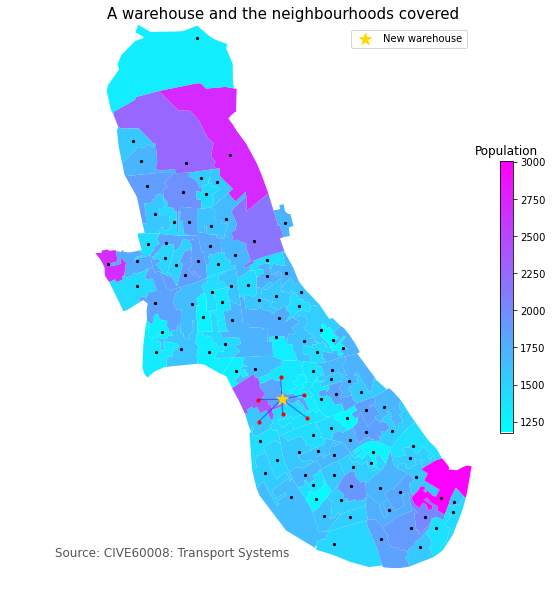

In [12]:
# Plot the map, main centroid and centroids within the 0.5 km radius

# Create plot and set equal axis
fig, ax = plt.subplots(1, figsize = (10,10))
ax.axes.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add a title
ax.set_title('A warehouse and the neighbourhoods covered', fontdict={'fontsize': '15', 'fontweight': '3'})

# Remove the axis for better presentation
ax.axis('off') 

# Plot using a cool colormap
ldn_df.plot(ax=ax,alpha=1, column='population', cmap='cool')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='cool', norm=plt.Normalize(vmin=ldn_df.population.min(), vmax=ldn_df.population.max()))# empty array for the data range
cbar = fig.colorbar(sm, shrink=0.5)

# Plot all the centroids
for k1,v1 in centroid_main.items():
    for k2,v2 in centroid_set.items():
        if k2 in coverage_matrix[k1]:
            ax.scatter(x=v2.x, y=v2.y, s=10, color='red', marker='o', zorder = 2) # Red in colour if within 0.5km
        else:
            ax.scatter(x=v2.x, y=v2.y, s=5, color='black', marker='o', zorder = 2) # Black in colour if otherwise

# Connect the main centroid with the centroids within 0.5km
for k1,v1 in centroid_main.items():
    for k2,v2 in centroid_set.items():
        if k2 in coverage_matrix[k1]:
            ax.plot([v1.x, v2.x],[v1.y,v2.y], color='blue',alpha=0.5, linewidth=1, zorder = 1)
            
# Plot the main centroid
for k1,v1 in centroid_main.items():
    ax.scatter(x=v1.x, y=v1.y, s= 150, color='gold', marker='*', edgecolor='gold', label='New warehouse', zorder = 2)
    
# Annotate and add source
ax.annotate('Source: CIVE60008: Transport Systems',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='#555555')

# Plot legend
legend = ax.legend()

# Color bar title
cbar.ax.set_title("Population", size = 12);

### Task 1.3: Shortlist 5 warehouse locations with the highest population coverage and plot their locations 

In [13]:
# Calculation for all the centroids that are within 0.5km of each centroid

# Store the coverage matrix and centroid in dictionaries
coverage_matrix_rank = {}
centroid_main_rank = {}
i = 0

# Calculation of point coverage for all centroids
for centroid_loop in ldn_df['geometry']:
    i+=1
    centroid_main = {'main': centroid_loop}
    dist_dict = {}
    for k1, v1 in centroid_main.items():
        for k2, v2 in centroid_set.items():
            dist_dict[(k1,k2)] = haversine_np(v1.x,v1.y,v2.x,v2.y)
    
    
    max_distance = 0.5
    coverage_matrix = {}
    for k1, v1 in centroid_main.items():
        coverage_matrix[k1] = {}
        for k2, v2 in centroid_set.items():
            if dist_dict[(k1,k2)] <= max_distance:
                coverage_matrix[k1][k2] = 1
    
    # Store the points of coverage
    coverage_matrix_rank['main'+str(i)] = coverage_matrix
    centroid_main_rank['main'+str(i)] = centroid_loop

In [14]:
# Create a dictionary for the population associated with each centroid
centroid_population = dict(zip(list('pt'+ str(i) for i in ldn_df['lsoa_code']), ldn_df['population']))

# Create empty lists to store the population coverage of each centroid and the centroid itself
coverage_of_centroids = []
centroids_list = []

# Calculation of the population that can be covered by the main centroid and the centroids within 0.5km radius
for centroid, values_matrix in coverage_matrix_rank.items():
    for key in values_matrix.values():
        list_population = [] # Create list to store population of main centroid and centroids within 0.5km
        for centroids_nearby in key:
            list_population.append(centroid_population[centroids_nearby])
        coverage_of_centroids.append(sum(list_population)) # Sum all the population of main centroid and centroids within 0.5km
        centroids_list.append(centroid) # Storing centroids

# Create dataframe for centroid, lsoa name and  population covered to sort
coverage_rank = pd.DataFrame()
coverage_rank['Centroid name'] = list(ldn_df['lsoa_name'])
coverage_rank['Centroid LSOA'] = list(ldn_df['lsoa_code'])
coverage_rank['Centroids'] = centroids_list
coverage_rank['Coverage area population'] = coverage_of_centroids

# Sort the dataframe
coverage_rank.sort_values(by = ['Coverage area population'], axis=0, ascending=False).head(5)

# Store the 5 centroids with the highest coverage
highest_five_centroids = coverage_rank.sort_values(by = ['Coverage area population'], axis=0, ascending=False)[:5]

# Output the coordinates of the 5 centroids with the highest coverage
highest_five_centroids

,Centroid name,Centroid LSOA,Centroids,Coverage area population
58,Hammersmith and Fulham 015C,E01001909,main59,16889
84,Hammersmith and Fulham 023A,E01001935,main85,16509
50,Hammersmith and Fulham 019B,E01001901,main51,16170
31,Hammersmith and Fulham 017C,E01001882,main32,15658
103,Hammersmith and Fulham 002A,E01001955,main104,15578


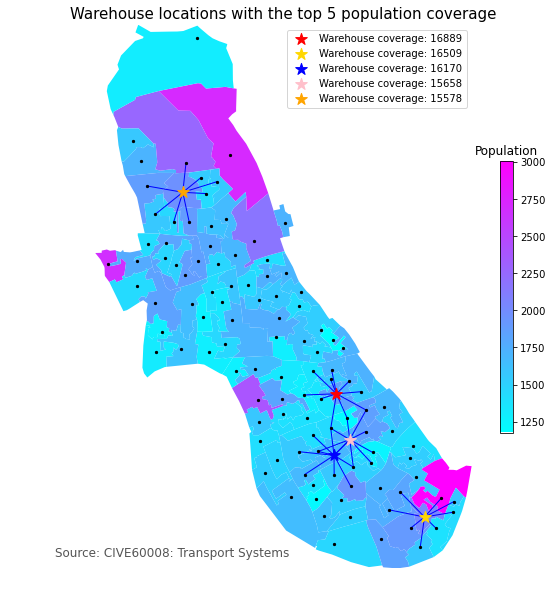

In [15]:
# Plot the 5 centroids on the map

# Create plot and set equal axis
fig, ax = plt.subplots(1, figsize = (10,10))
ax.axes.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add a title
ax.set_title('Warehouse locations with the top 5 population coverage', fontdict={'fontsize': '15', 'fontweight': '3'})

# Remove the axis for better presentation
ax.axis('off') 

# Plot using a cool colormap
ldn_df.plot(ax=ax, alpha=1, column='population', cmap='cool')

# Plot all the centroids
for k1,v1 in centroid_main.items():
    for k2,v2 in centroid_set.items():
        ax.scatter(x=v2.x, y=v2.y, s=5, color='black', marker='o', zorder = 2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='cool', norm=plt.Normalize(vmin=ldn_df.population.min(), vmax=ldn_df.population.max()))# empty array for the data range
cbar = fig.colorbar(sm, shrink=0.5)

# Set different colors for different warehouses
legend_color = ['red', 'gold', 'blue', 'pink', 'orange']

# Connect the main centroid with the centroids within 0.5km
for centroids in highest_five_centroids.Centroids:
    plot_centroid = {centroids: centroid_main_rank[centroids]}
    for k1,v1 in plot_centroid.items():
        for k2,v2 in centroid_set.items():
            if k2 in coverage_matrix_rank[k1]['main']:
                ax.plot([v1.x, v2.x],[v1.y,v2.y], zorder = 1, color='blue',alpha=1, linewidth=1)
                
# Create loop to make plot for each warehouse
i = 0
for centroids in highest_five_centroids.Centroids:
    plot_centroid = {centroids: centroid_main_rank[centroids]} # Create dictionary of centroids: centroids to ease data manipulation
    i+=1
    # Plot the main centroid chosen before
    for k1,v1 in plot_centroid.items():
        ax.scatter(x=v1.x, y=v1.y, s=150, zorder = 2, color=legend_color[i-1], marker='*', edgecolor=legend_color[i-1], label= 'Warehouse coverage: ' + str(list(highest_five_centroids['Coverage area population'])[i-1]))

# Plot legends
legend = ax.legend()

# Annotate and add source
ax.annotate('Source: CIVE60008: Transport Systems',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='#555555');

# Color bar title
cbar.ax.set_title("Population", size = 12);

### Is this a good selection?

With the code developed in the previous task, the warehouse locations with the highest population covered are identified and plotted in Figure 2.3. Based on the map, the selected centroids are not a good selection of warehouses in the first instance. It can be observed that the coverage population are overlapping and the uptake from the same population is not directly proportional to the amount of warehouse coverage. Instead of catering to existing customers, warehouses should be established with a goal to offer new customers its service and expand the business over a broader range of neighbourhoods. A more sophisticated selection strategy is required to account for overlapping coverage.

## Task 2: Initial Location Selection

### Task 2.2: Use PuLP to determine (and visualise) the locations of the optimal combination of depots.

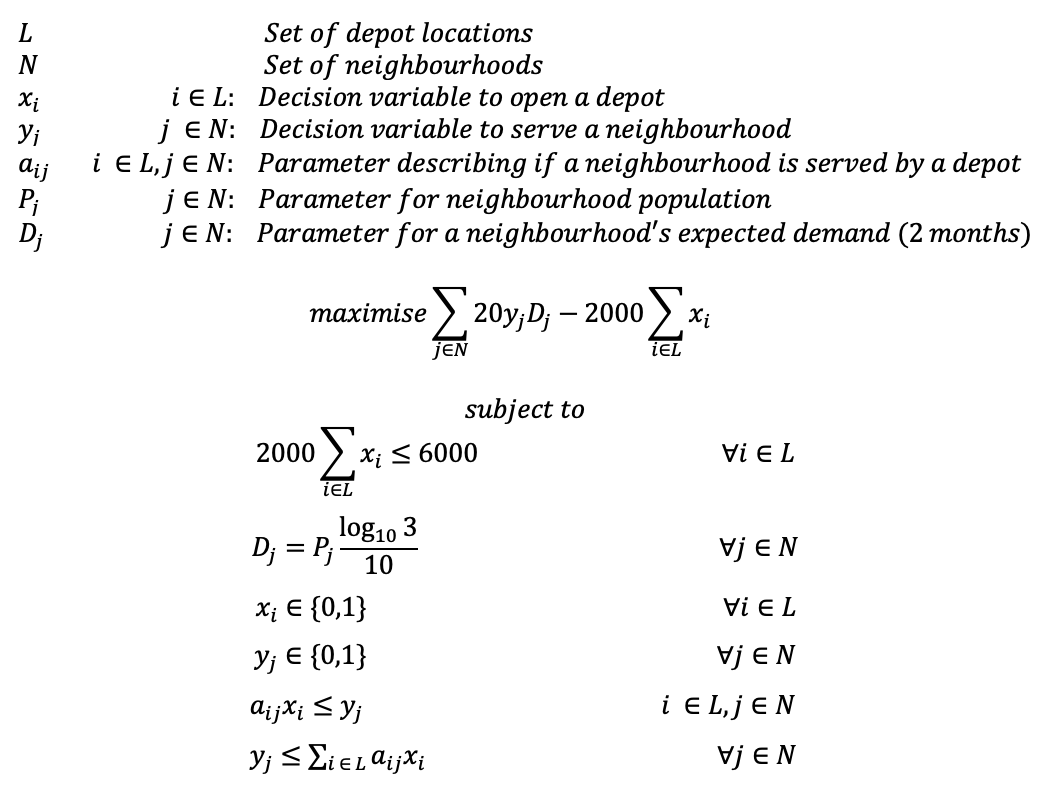

In [16]:
# Setting problem
prob = LpProblem('prob', LpMaximize)

# Setting centroids and population
centroid_prob = ['C'+str(i) for i in ldn_df['lsoa_code']] # Centroid/warehouse locations
neighbourhood_prob = ['pt'+str(i) for i in ldn_df['lsoa_code']] # Neighbourhood

# Population dictionary
pop_dict = {}
i = 0
t = 0 # For this question
for pop in list(ldn_df.population):
    pop_dict['pt'+str(list(ldn_df['lsoa_code'])[i])] = pop
    i +=1
    
# Coverage dictionary
cover_dict = {}
i = 0
for key1,value1 in coverage_matrix_rank.items():
    for key2, value2 in value1.items():
        cover_dict['C'+str(list(ldn_df['lsoa_code'])[i])] = value2
        i +=1

In [17]:
# Declaring decision variables. 
x = LpVariable.dicts('x', centroid_prob, lowBound = 0, upBound = 1, cat = LpInteger) # Is a centroid a warehouse?
y = LpVariable.dicts('y', neighbourhood_prob, lowBound = 0,upBound = 1,cat = LpInteger) # Is a neighbourhood covered?

In [18]:
# Define objective equation: maximize profit
t = 0 # For this question
prob += lpSum(20*pop_dict[j]*np.log10(3+3*t)/10*y[j] for j in neighbourhood_prob) - lpSum(x[i]*2000 for i in centroid_prob)

# Define constraints: cost below 100
initial_budget = 6000
prob += lpSum(x[i]*2000 for i in centroid_prob) <= initial_budget

# Define constraints: a neighbourhood is covered if a warehouse within range is selected
for i in centroid_prob:
    for j in neighbourhood_prob:
        if j in cover_dict[i]:
            prob += cover_dict[i][j]*x[i] <= y[j]

# Define constraints: if a neighbourhood is covered, new warehouses must not consider it
for j in neighbourhood_prob:
    prob += y[j] <= lpSum(cover_dict[i][j]*x[i] for i in centroid_prob if j in cover_dict[i] if i in cover_dict.keys())


In [19]:
# Solving problem
status = prob.solve()
print(f'The solution is: {LpStatus[status]}\n')

print('Total profit:', prob.objective.value())

print('')

print('Established warehouses:\n')

# Print LSOA code of new warehouses
pulp_three_lsoa_code = []
for v in list(x.values()):
    if v.varValue == 1:
        print(f'  - {ldn_df.lsoa_name[ldn_df.lsoa_code == v.name.replace("x_C","")].to_string()} ')
        
        # Store list of station lsoa
        pulp_three_lsoa_code.append(str(v.name.replace("x_C","")))

The solution is: Optimal

Total profit: 40734.98114230038

Established warehouses:

  - 1862    Hammersmith and Fulham 015C 
  - 1888    Hammersmith and Fulham 023A 
  - 1907    Hammersmith and Fulham 002A 


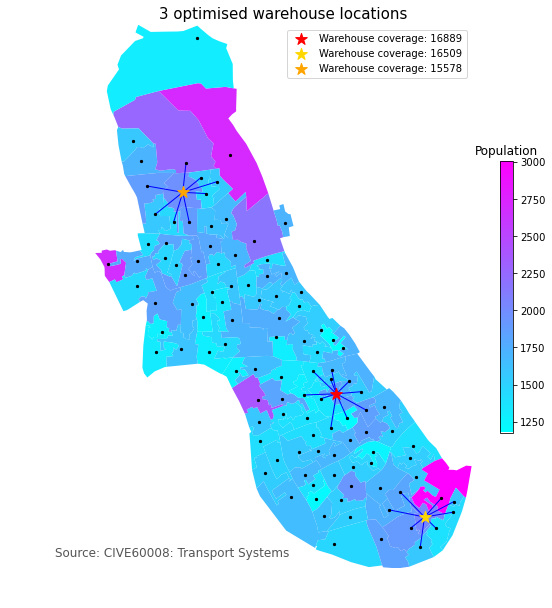

In [20]:
# Plot the 5 centroids on the map

# Create plot and set equal axis
fig, ax = plt.subplots(1, figsize = (10,10))
ax.axes.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add a title
ax.set_title('3 optimised warehouse locations', fontdict={'fontsize': '15', 'fontweight': '3'})

# Remove the axis for better presentation
ax.axis('off') 

# Plot using a cool colormap
ldn_df.plot(ax=ax,alpha=1, column='population', cmap='cool')

# Plot all the centroids
for v in ldn_df['geometry']:
        ax.scatter(x=v.x, y=v.y, zorder = 2, s=5, color='black', marker='o')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='cool', norm=plt.Normalize(vmin=ldn_df.population.min(), vmax=ldn_df.population.max()))# empty array for the data range
cbar = fig.colorbar(sm, shrink=0.5)

# Set different colors for different warehouses
legend_color = ['red', 'gold', 'orange']

# Create dataframe for three points selected
pulp_three_centroids = []
for code in pulp_three_lsoa_code:
    pulp_three_centroids.append(coverage_rank.Centroids[coverage_rank['Centroid LSOA'] == str(code)].to_string(index = False))

# Create loop to make plot for each warehouse
i = 0
for centroids in pulp_three_centroids:
    plot_centroid = {centroids: centroid_main_rank[centroids]} # Create dictionary of centroids: centroids to ease data manipulation
    i+=1
    # Plot the main centroid chosen before
    for k1,v1 in plot_centroid.items():
        ax.scatter(x=v1.x, y=v1.y, s=150, zorder = 2, color=legend_color[i-1], marker='*', edgecolor=legend_color[i-1], label= 'Warehouse coverage: ' + coverage_rank['Coverage area population'][coverage_rank['Centroids'] == centroids].to_string(index = False))

# Connect the main centroid with the centroids within 0.5km
for centroids in pulp_three_centroids:
    plot_centroid = {centroids: centroid_main_rank[centroids]}
    for k1,v1 in plot_centroid.items():
        for k2,v2 in centroid_set.items():
            if k2 in coverage_matrix_rank[k1]['main']:
                ax.plot([v1.x, v2.x],[v1.y,v2.y], zorder = 1, color='blue',alpha=1, linewidth=1)
        
# plt.axis('scaled')
legend = ax.legend()

# Annotate and add source
ax.annotate('Source: CIVE60008: Transport Systems',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='#555555');

# Color bar title
cbar.ax.set_title("Population", size = 12);

## Task 3: Expansion Modelling

### Task 3.1: Develop a facility expansion plan for the duration of the trial period, expansion only takesplace if enough funds are available.

- Based on the brief, the demand for each warehouse is dependent on the starting period of expansion (independent of the operating duration of each warehouse). Therefore, analysis is performed to see how the expansion plan would look like. 

In [21]:
## CREATE VARIABLES TO STORE VALUES FOR DATAFRAME OR ITERATE

# Initiate trial time
month_trial = list(range(0,12,2))

# Create array for budget
initial_budget = np.zeros(len(month_trial)+1)
initial_budget[0] = 6000

# Money not used for expansion
savings = np.zeros(len(month_trial)+1)

# Create array for number of new warehouse
exist_facility = []

# Number of existing warehouse
number_facility = 0

# Population covered
population_covered_in_phase = np.zeros(len(month_trial))

# Population dictionary (needed to manipulate expansion)
pop_dict_expansion = pop_dict.copy()

# Percentage of population covered
expansion_percentage = []

# Coverage status for plot
expansion_status ={}
    
# Store the left over money for next expansion
left_over_money = []

# Constant to carry forward left over expansion money
carry_forward = 0

# Profit from existing warehouses
exist_profit = 0

In [22]:
for time in list(range(0,len(month_trial))):
    
    # Setting problem
    prob_expansion = LpProblem('prob_expansion', LpMaximize)

    # Declaring decision variables. 
    x_expansion = LpVariable.dicts('x', centroid_prob, lowBound = 0, upBound = 1, cat = LpInteger) # Is a centroid a warehouse?
    y_expansion = LpVariable.dicts('y', neighbourhood_prob, lowBound = 0,upBound = 1,cat = LpInteger) # Is a neighbourhood covered?
    
    # Calculate profit from existing warehouses, since the start of expansion
    exist_profit = sum(population_covered_in_phase)*20*np.log10(3+3*month_trial[time])/10
    
    # Define objective equation: maximize profit of new warehouses (profit from old ware houses are added as exist_profit)
    prob_expansion += lpSum(20*pop_dict_expansion[j]*np.log10(3+3*month_trial[time])/10*y_expansion[j] for j in neighbourhood_prob) - lpSum(x_expansion[i]*2000 for i in centroid_prob) - number_facility * 2000 + exist_profit 

    # Define constraints: cost below expansion budget
    prob_expansion += lpSum(x_expansion[i]*2000 for i in centroid_prob) <= initial_budget[time]

    # Define constraints: a neighbourhood is covered if a warehouse within range is selected
    for i in centroid_prob:
        for j in neighbourhood_prob:
            if j in cover_dict[i]:
                prob_expansion += cover_dict[i][j]*x_expansion[i] <= y_expansion[j]

    # Define constraints: if a neighbourhood is covered, new warehouses must not consider it
    for j in neighbourhood_prob:
        prob_expansion += y_expansion[j] <= lpSum(cover_dict[i][j]*x_expansion[i] for i in centroid_prob if j in cover_dict[i] if i in cover_dict.keys())

    # Solve problem
    status_expansion = prob_expansion.solve()
    
    # Output results
    print(f'Expansion month: ' + str(month_trial[time]) + '\n')
          
    print(f'The solution is: {LpStatus[status_expansion]}\n')

    print('Total profit:', prob_expansion.objective.value())

    print('')

    print('Established warehouses:\n')
    
    ## STORE VALUES NEEDED TO CREATE DATAFRAME
    
    # Print and store lsoa code of stations selected
    pulp_expansion_lsoa_code = []
    for v in list(x_expansion.values()):
        if v.varValue == 1:
            print(f'  - {ldn_df.lsoa_name[ldn_df.lsoa_code == v.name.replace("x_C","")].to_string()} ')
            # Store list of station lsoa
            pulp_expansion_lsoa_code.append(str(v.name.replace("x_","")))
            
    # Change covered neighbourhood and centroid population to zero, to avoid overlapping demand with exist_profit avriable above
    population_covered = 0
    for i in pulp_expansion_lsoa_code:
        for j in cover_dict[i]:
            population_covered += pop_dict_expansion[j] # Store the population covered
            pop_dict_expansion[j]=0
            
    # Carry forward the population covered previously onto the next phase of expansion
    population_covered_in_phase[1:] = population_covered_in_phase[:-1]
    
    # Store the population covered in the current phase
    population_covered_in_phase[0] = population_covered                            
    print('')
    print('The population covered by these warehouse is:'+ str(sum(population_covered_in_phase)))
    
    # Store the percentage of area covered
    expansion_percentage.append(sum(population_covered_in_phase)/sum(ldn_df.population)*100)
    
    # Store the coverage status of each expansion
    expansion_status[str(month_trial[time])] =[]
    for key, value in pop_dict_expansion.items():
        if value !=0:
            expansion_status[str(month_trial[time])].append(1)
        else:
            expansion_status[str(month_trial[time])].append(0)
            
    # Store money not used for expansion
    savings[time +1] += 0.85*prob_expansion.objective.value() 
   
    # Store stations that need to be opened
    exist_facility.append(pulp_expansion_lsoa_code)
    
    ## UPDATE VALUES THAT ARE NEEDED FOR THE NEXT ITERATION
    
    # Count the number of stations that are already open
    number_facility+=len(pulp_expansion_lsoa_code)
    
    # Bring forward leftover start up budget to next iteration
    carry_forward = initial_budget[time] - len(pulp_expansion_lsoa_code) * 2000
    left_over_money.append(carry_forward)
    
    # Store initial budget for expansion
    initial_budget[time +1] = 0.15*prob_expansion.objective.value() + carry_forward        

    print('')
    print('---------------------')

Expansion month: 0

The solution is: Optimal

Total profit: 40734.98114230038

Established warehouses:

  - 1862    Hammersmith and Fulham 015C 
  - 1888    Hammersmith and Fulham 023A 
  - 1907    Hammersmith and Fulham 002A 

The population covered by these warehouse is:48976.0

---------------------
Expansion month: 2

The solution is: Optimal

Total profit: 161187.38152316195

Established warehouses:

  - 1804    Hammersmith and Fulham 010A 
  - 1848    Hammersmith and Fulham 009A 
  - 1854    Hammersmith and Fulham 019B 

The population covered by these warehouse is:90746.0

---------------------
Expansion month: 4

The solution is: Optimal

Total profit: 372468.2551826288

Established warehouses:

  - 1818    Hammersmith and Fulham 008B 
  - 1819    Hammersmith and Fulham 012A 
  - 1828    Hammersmith and Fulham 001B 
  - 1833    Hammersmith and Fulham 017A 
  - 1843    Hammersmith and Fulham 016C 
  - 1846    Hammersmith and Fulham 013A 
  - 1872    Hammersmith and Fulham 018E 


In [23]:
# Create DataFrame for the expansion plan
expansion_plan = pd.DataFrame()
expansion_plan['Expansion month'] = month_trial
expansion_plan['Budget available for current expansion (£)'] = initial_budget[:len(month_trial)]
expansion_plan['Budget not used for expansion (£)'] = savings[:len(month_trial)]
expansion_plan['Number of new facilities'] = [len(n) for n in exist_facility]
expansion_plan['Percentage of population covered (%)'] = expansion_percentage
expansion_plan['Leftover budget for next expansion (£)'] = left_over_money

expansion_plan

,Expansion month,Budget available for current expansion (£),Budget not used for expansion (£),Number of new facilities,Percentage of population covered (%),Leftover budget for next expansion (£)
0,0,6000.000000,0.000000,3,26.683520,0.000000
1,2,6110.247171,34624.733971,3,49.441006,110.247171
2,4,24288.354400,137009.274295,12,94.612191,288.354400
3,6,56158.592677,316598.016905,6,100.000000,44158.592677
4,8,109764.218147,371765.210995,0,100.000000,109764.218147
5,10,181379.687366,405820.992239,0,100.000000,181379.687366


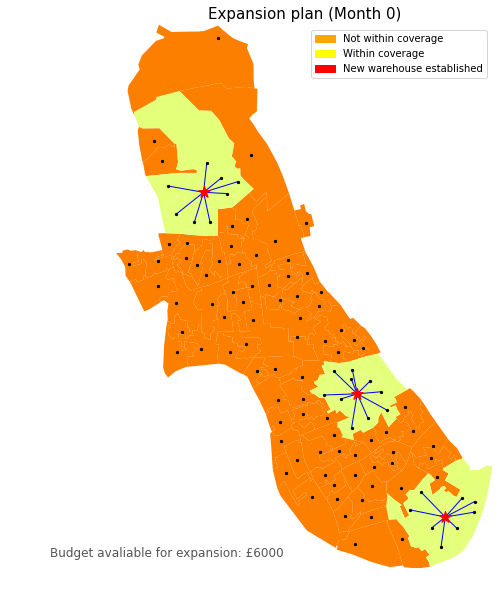

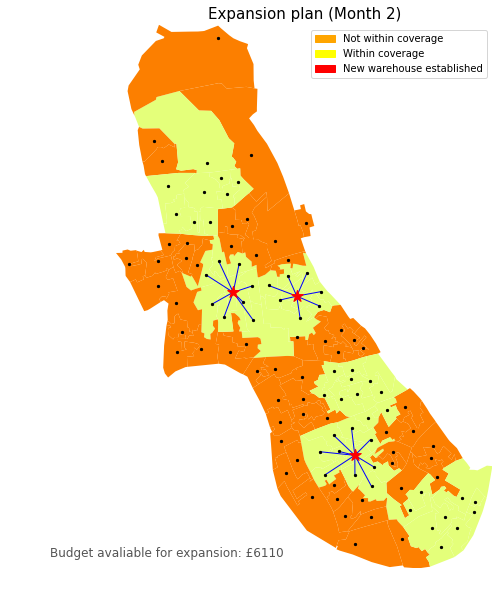

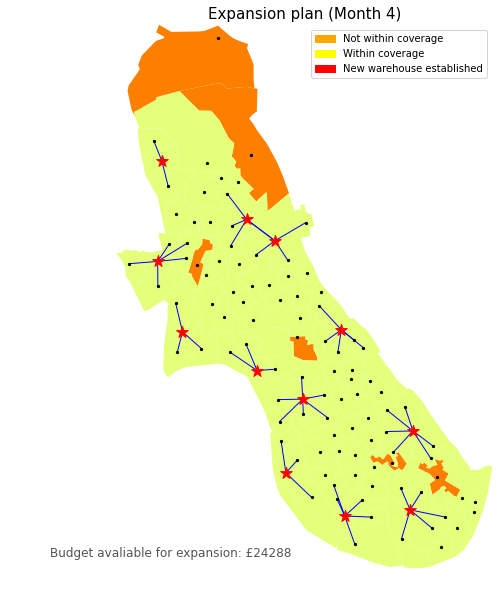

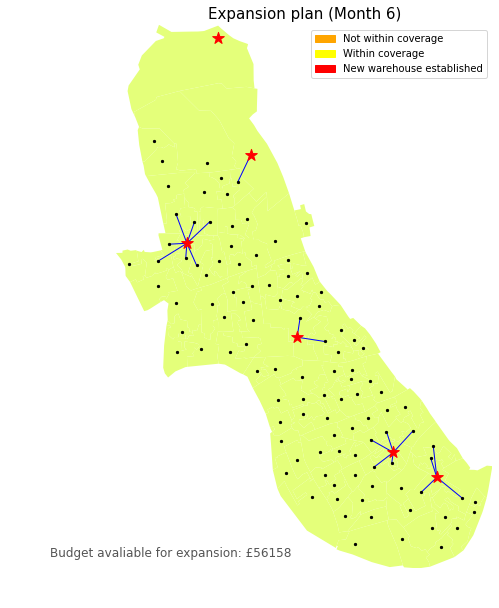

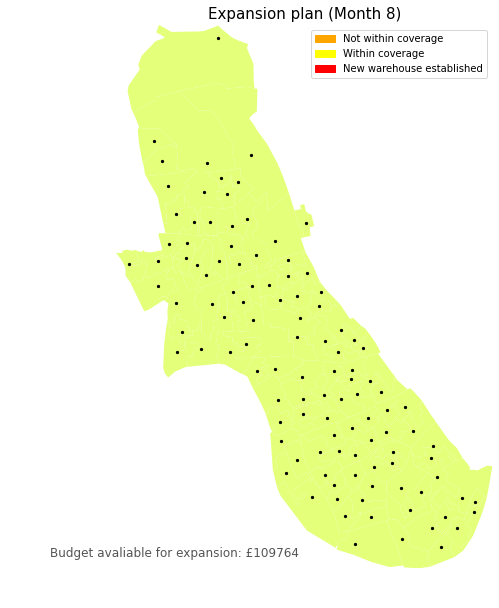

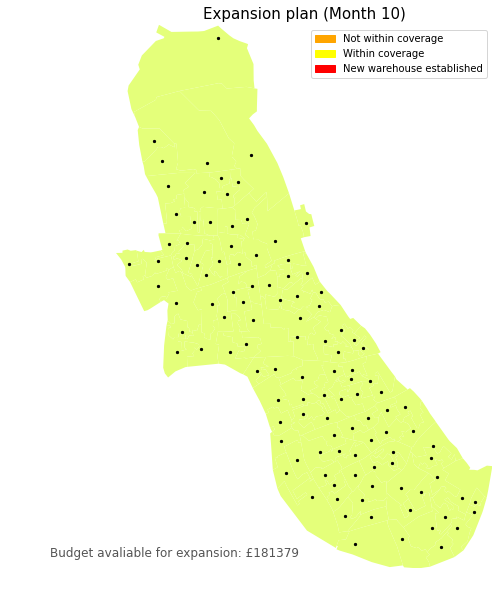

In [24]:
for time in list(range(0,len(month_trial))):
    # Create plot and set equal axis
    fig, ax = plt.subplots(1, figsize = (10,10))
    ax.axes.set_aspect('equal')
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Add a title
    ax.set_title('Expansion plan (Month ' + str(month_trial[time]) +')', fontdict={'fontsize': '15', 'fontweight': '3'})

    # Remove the axis for better presentation
    ax.axis('off') 

    # Plot using a Wistia colormap
    ldn_df['coverage_status'] = expansion_status[str(month_trial[time])]
    ldn_df.plot(ax=ax,alpha=1, column='coverage_status', cmap='Wistia')

    # Plot all the centroids
    for v in ldn_df['geometry']:
        ax.scatter(x=v.x, y=v.y, s=5,zorder = 2, color='black', marker='o')
    
    # Create a list of centroid for all new warehouses
    pulp_expansion_lsoa_plot = []
    for code in exist_facility[time]:
        pulp_expansion_lsoa_plot.append(coverage_rank.Centroids[coverage_rank['Centroid LSOA'] == str(code.replace("C",""))].to_string(index = False))

    # Create loop to plot new facilities
    i = 0
    for centroids in pulp_expansion_lsoa_plot:
        plot_centroid = {centroids: centroid_main_rank[centroids]} # Create dictionary of centroids: centroids to ease data manipulation
        i+=1
        # Plot the main centroid chosen before
        for k1,v1 in plot_centroid.items():
            ax.scatter(x=v1.x, y=v1.y, s=150, zorder = 2, color='red', marker='*', edgecolor='red', label= 'Warehouse coverage: ' + coverage_rank['Coverage area population'][coverage_rank['Centroids'] == centroids].to_string(index = False))
            
    # Connect the main centroid with the centroids within 0.5km
    for centroids in pulp_expansion_lsoa_plot:
        plot_centroid = {centroids: centroid_main_rank[centroids]}
        for k1,v1 in plot_centroid.items():
            for k2,v2 in centroid_set.items():
                if k2 in coverage_matrix_rank[k1]['main']:
                    ax.plot([v1.x, v2.x],[v1.y,v2.y], zorder = 1, color='blue',alpha=1, linewidth=1)

    # Annotate and add source
    ax.annotate('Budget avaliable for expansion: £' + str(int(initial_budget[time])),xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='#555555');

    # Legend for coverage
    orange_patch = mpatches.Patch(color='orange', label='Not within coverage')
    yellow_patch = mpatches.Patch(color='yellow', label='Within coverage')
    red_star = mpatches.Patch(color='red', label='New warehouse established')
    ax.legend(handles=[orange_patch, yellow_patch, red_star], prop={'size': 10});
    

# What if the warehouse demand does not increase based on the month it is opened?

- Based on the analysis above, the mathematical model is an overestimate of the potential profit that each warehouse would obtain (a warehouse operating for 4 months would not generate the same demand as a new warehouse opened in month 4).


- To obtain a more reasonable expansion plan, the demand is modelled with the operation duration of each warehouse. 


- In this version, the exist_profit variable is changed such that it accounts for the operation duration of each warehouse.

In [25]:
## CREATE VARIABLES TO STORE VALUES FOR DATAFRAME OR ITERATE

# Initiate trial time
month_trial = list(range(0,12,2))

# Create array for budget
initial_budget = np.zeros(len(month_trial)+1)
initial_budget[0] = 6000

# Money not used for expansion
savings = np.zeros(len(month_trial)+1)

# Create array for number of new warehouse
exist_facility = []

# Number of existing warehouse
number_facility = 0

# Population covered
population_covered_in_phase = np.zeros(len(month_trial))

# Population dictionary (needed to manipulate expansion)
pop_dict_expansion = pop_dict.copy()

# Percentage of population covered
expansion_percentage = []

# Coverage status for plot
expansion_status ={}

# Profit at different 2-month interval (before accounting population)
exist_demand = []
for t in month_trial[1:]:
    exist_demand.append(20*np.log10(3+3*t)/10)
    
# Store the left over money for next expansion
left_over_money = []

# Constant to carry forward left over expansion money
carry_forward = 0

In [26]:
for time in list(range(0,len(month_trial))):
    
    # Setting problem
    prob_expansion = LpProblem('prob_expansion', LpMaximize)

    # Declaring decision variables. 
    x_expansion = LpVariable.dicts('x', centroid_prob, lowBound = 0, upBound = 1, cat = LpInteger) # Is a centroid a warehouse?
    y_expansion = LpVariable.dicts('y', neighbourhood_prob, lowBound = 0,upBound = 1,cat = LpInteger) # Is a neighbourhood covered?
    
    # Calculate profit from existing warehouses, based on how long the neighbourhood has been served
    exist_profit = sum([exist_demand[i] * population_covered_in_phase[i] for i in range(0,len(month_trial)-1)])
    
    # Define objective equation: maximize profit
    prob_expansion += lpSum(20*pop_dict_expansion[j]*np.log10(3)/10*y_expansion[j] for j in neighbourhood_prob) - lpSum(x_expansion[i]*2000 for i in centroid_prob) - number_facility * 2000 + exist_profit 

    # Define constraints: cost below expansion budget
    prob_expansion += lpSum(x_expansion[i]*2000 for i in centroid_prob) <= initial_budget[time]

    # Define constraints: a neighbourhood is covered if a warehouse within range is selected
    for i in centroid_prob:
        for j in neighbourhood_prob:
            if j in cover_dict[i]:
                prob_expansion += cover_dict[i][j]*x_expansion[i] <= y_expansion[j]
    
    # Define constraints: if a neighbourhood is covered, new warehouses must not consider it
    for j in neighbourhood_prob:
        prob_expansion += y_expansion[j] <= lpSum(cover_dict[i][j]*x_expansion[i] for i in centroid_prob if j in cover_dict[i] if i in cover_dict.keys())

    # Solve problem
    status_expansion = prob_expansion.solve()
    
    # Output results
    print(f'Expansion month: ' + str(month_trial[time]) + '\n')
    
    print(f'The solution is: {LpStatus[status_expansion]}\n')

    print('Total profit:', prob_expansion.objective.value())

    print('')

    print('Established warehouses:\n')
    
    ## STORE VALUES NEEDED TO CREATE DATAFRAME
    
    # Print and store lsoa code of stations selected
    pulp_expansion_lsoa_code = []
    for v in list(x_expansion.values()):
        if v.varValue == 1:
            print(f'  - {ldn_df.lsoa_name[ldn_df.lsoa_code == v.name.replace("x_C","")].to_string()} ')
            # Store list of station lsoa
            pulp_expansion_lsoa_code.append(str(v.name.replace("x_","")))
            
    # Change covered neighbourhood and centroid population to zero, to avoid overlapping demand with exist_profit variable above
    population_covered = 0
    for i in pulp_expansion_lsoa_code:
        for j in cover_dict[i]:
            population_covered += pop_dict_expansion[j] # Store the population covered
            pop_dict_expansion[j]=0
            
    # Carry forward the population covered previously onto the next phase of expansion
    population_covered_in_phase[1:] = population_covered_in_phase[:-1]
    
    # Store the population covered in the current phase
    population_covered_in_phase[0] = population_covered                            
    print('')
    print('The population covered by these warehouse is:'+ str(sum(population_covered_in_phase)))
    
    # Store the percentage of area covered
    expansion_percentage.append(sum(population_covered_in_phase)/sum(ldn_df.population)*100)
    
    # Store the coverage status of each expansion
    expansion_status[str(month_trial[time])] =[]
    for key, value in pop_dict_expansion.items():
        if value !=0:
            expansion_status[str(month_trial[time])].append(1)
        else:
            expansion_status[str(month_trial[time])].append(0)
        
    # Store money not used for expansion
    savings[time +1] += 0.85*prob_expansion.objective.value() 
   
    # Store stations that need to be opened
    exist_facility.append(pulp_expansion_lsoa_code)
    
    ## UPDATE VALUES THAT ARE NEEDED FOR THE NEXT ITERATION
    
    # Count the number of stations that are already open
    number_facility+=len(pulp_expansion_lsoa_code)
    
    # Bring forward leftover start up budget to next iteration
    carry_forward = initial_budget[time] - len(pulp_expansion_lsoa_code) * 2000
    left_over_money.append(carry_forward)
    
    # Store initial budget for expansion
    initial_budget[time +1] = 0.15*prob_expansion.objective.value() + carry_forward
    
    print('')
    print('---------------------')

Expansion month: 0

The solution is: Optimal

Total profit: 40734.98114230038

Established warehouses:

  - 1862    Hammersmith and Fulham 015C 
  - 1888    Hammersmith and Fulham 023A 
  - 1907    Hammersmith and Fulham 002A 

The population covered by these warehouse is:48976.0

---------------------
Expansion month: 2

The solution is: Optimal

Total profit: 121328.67190388132

Established warehouses:

  - 1804    Hammersmith and Fulham 010A 
  - 1848    Hammersmith and Fulham 009A 
  - 1854    Hammersmith and Fulham 019B 

The population covered by these warehouse is:90746.0

---------------------
Expansion month: 4

The solution is: Optimal

Total profit: 234236.9488587841

Established warehouses:

  - 1818    Hammersmith and Fulham 008B 
  - 1819    Hammersmith and Fulham 012A 
  - 1833    Hammersmith and Fulham 017A 
  - 1843    Hammersmith and Fulham 016C 
  - 1846    Hammersmith and Fulham 013A 
  - 1872    Hammersmith and Fulham 018E 
  - 1884    Hammersmith and Fulham 011B 


In [27]:
# Create DataFrame for the expansion plan
expansion_plan = pd.DataFrame()
expansion_plan['Expansion month'] = month_trial
expansion_plan['Budget available for current expansion (£)'] = initial_budget[:len(month_trial)]
expansion_plan['Budget not used for expansion (£)'] = savings[:len(month_trial)]
expansion_plan['Number of new facilities'] = [len(n) for n in exist_facility]
expansion_plan['Percentage of population covered (%)'] = expansion_percentage
expansion_plan['Leftover budget for next expansion (£)'] = left_over_money

expansion_plan

,Expansion month,Budget available for current expansion (£),Budget not used for expansion (£),Number of new facilities,Percentage of population covered (%),Leftover budget for next expansion (£)
0,0,6000.000000,0.000000,3,26.683520,0.000000
1,2,6110.247171,34624.733971,3,49.441006,110.247171
2,4,18309.547957,103129.371118,9,89.018982,309.547957
3,6,35445.090286,199101.406530,4,96.088676,27445.090286
4,8,78562.842711,289667.263743,0,96.088676,78562.842711
5,10,139807.428648,347052.653641,0,96.088676,139807.428648


## Develop plots to visualize expansion plans

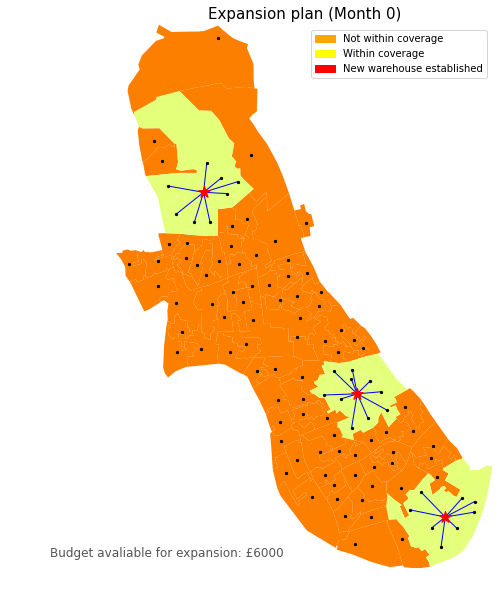

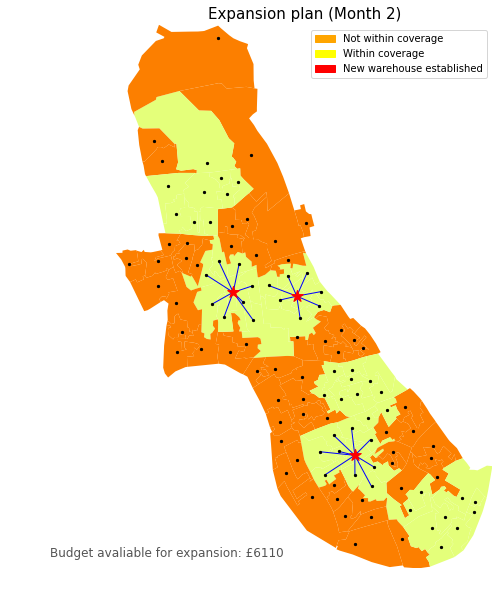

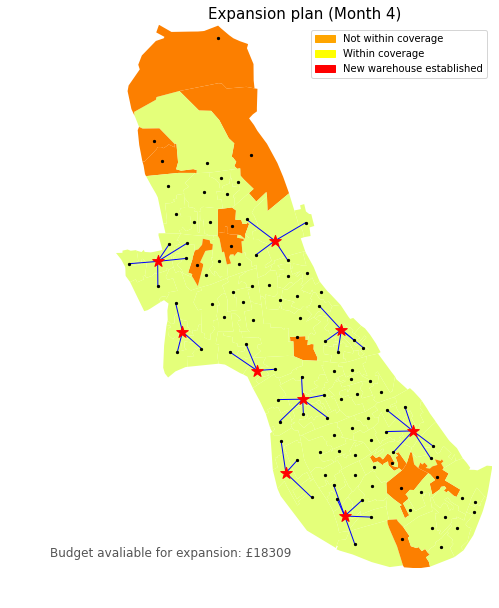

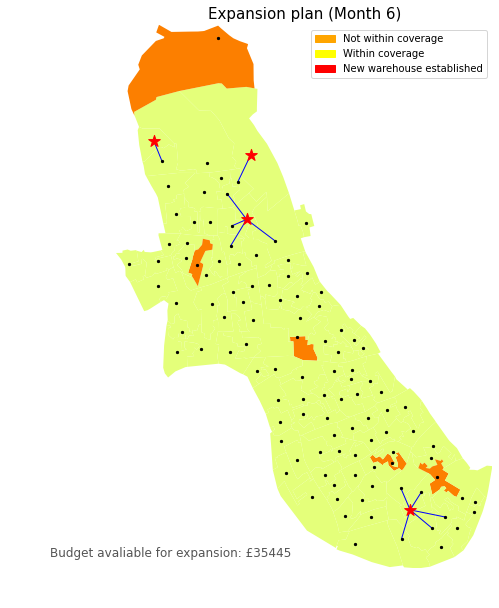

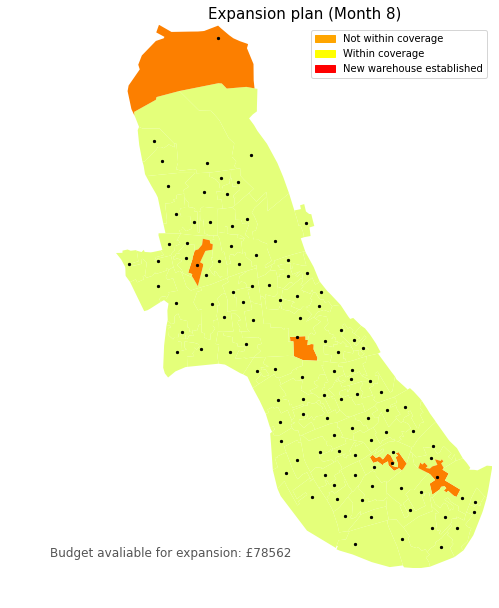

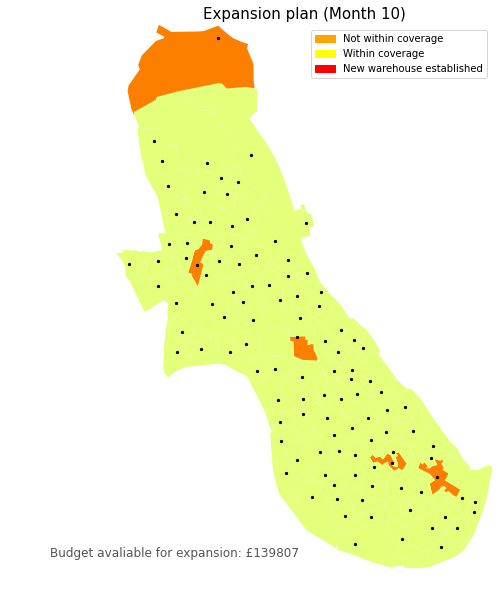

In [28]:
for time in list(range(0,len(month_trial))):
    # Create plot and set equal axis
    fig, ax = plt.subplots(1, figsize = (10,10))
    ax.axes.set_aspect('equal')
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Add a title
    ax.set_title('Expansion plan (Month ' + str(month_trial[time]) +')', fontdict={'fontsize': '15', 'fontweight': '3'})

    # Remove the axis for better presentation
    ax.axis('off') 

    # Plot using a Wistia colormap
    ldn_df['coverage_status'] = expansion_status[str(month_trial[time])]
    ldn_df.plot(ax=ax,alpha=1, column='coverage_status', cmap='Wistia')

    # Plot all the centroids
    for v in ldn_df['geometry']:
        ax.scatter(x=v.x, y=v.y, s=5,zorder = 2, color='black', marker='o')
    
    # Create a list of centroid for all new warehouses
    pulp_expansion_lsoa_plot = []
    for code in exist_facility[time]:
        pulp_expansion_lsoa_plot.append(coverage_rank.Centroids[coverage_rank['Centroid LSOA'] == str(code.replace("C",""))].to_string(index = False))

    # Create loop to plot new facilities
    i = 0
    for centroids in pulp_expansion_lsoa_plot:
        plot_centroid = {centroids: centroid_main_rank[centroids]} # Create dictionary of centroids: centroids to ease data manipulation
        i+=1
        # Plot the main centroid chosen before
        for k1,v1 in plot_centroid.items():
            ax.scatter(x=v1.x, y=v1.y, s=150, zorder = 2, color='red', marker='*', edgecolor='red', label= 'Warehouse coverage: ' + coverage_rank['Coverage area population'][coverage_rank['Centroids'] == centroids].to_string(index = False))
            
    # Connect the main centroid with the centroids within 0.5km
    for centroids in pulp_expansion_lsoa_plot:
        plot_centroid = {centroids: centroid_main_rank[centroids]}
        for k1,v1 in plot_centroid.items():
            for k2,v2 in centroid_set.items():
                if k2 in coverage_matrix_rank[k1]['main']:
                    ax.plot([v1.x, v2.x],[v1.y,v2.y], zorder = 1, color='blue',alpha=1, linewidth=1)

    # Annotate and add source
    ax.annotate('Budget avaliable for expansion: £' + str(int(initial_budget[time])),xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='#555555');

    # Legend for coverage
    orange_patch = mpatches.Patch(color='orange', label='Not within coverage')
    yellow_patch = mpatches.Patch(color='yellow', label='Within coverage')
    red_star = mpatches.Patch(color='red', label='New warehouse established')
    ax.legend(handles=[orange_patch, yellow_patch, red_star], prop={'size': 10});
    

# Task 3.2: Extra

In [29]:
# Store savings of each section
end_year_profit = []
new_stations = []

# Begin looping for all boroughs
for boroughs in filter_name:
    
    # Extract London Borough dataset
    borough_df = excel_df[excel_df['lsoa_name'].str.contains(boroughs)]

    # Sort by LSOA code
    borough_df = borough_df.sort_values(by = ['lsoa_code'], axis=0, ascending=True)

    # Extract London Borough dataset
    ldn_df = gpd_df[gpd_df['lsoa_name'].str.contains(boroughs)]

    # Sort by LSOA code
    ldn_df = ldn_df.sort_values(by = ['lsoa_code'], axis=0, ascending=True)

    # Rename polygon column
    ldn_df.rename_geometry("polygon", inplace = True)
    
    # Convert latitude and longitude in excel to Geopandas
    centroids_df = gpd.GeoDataFrame(ldn_df, geometry=gpd.points_from_xy(borough_df.longitude, borough_df.latitude))
    
    # Append population
    ldn_df['population'] = list(borough_df['pop'])
    
    # Calculation for all the centroids that are within 0.5km of each centroid

    # Select a random main centroid from Hammersmith and Fulham Borough
    centroid_main = {'main': random.choice(list(ldn_df['geometry']))}

    # Create a dictionary of all centroids
    centroid_set = dict(zip(list('pt'+ str(i) for i in ldn_df['lsoa_code']), ldn_df['geometry']))

    # Store the coverage matrix and centroid in dictionaries
    coverage_matrix_rank = {}
    centroid_main_rank = {}
    i = 0

    # Calculation for all centroids
    for centroid_loop in ldn_df['geometry']:
        i+=1
        centroid_main = {'main': centroid_loop}
        dist_dict = {}
        for k1, v1 in centroid_main.items():
            for k2, v2 in centroid_set.items():
                dist_dict[(k1,k2)] = haversine_np(v1.x,v1.y,v2.x,v2.y)


        max_distance = 0.5
        coverage_matrix = {}
        for k1, v1 in centroid_main.items():
            coverage_matrix[k1] = {}
            for k2, v2 in centroid_set.items():
                if dist_dict[(k1,k2)] <= max_distance:
                    coverage_matrix[k1][k2] = 1

        coverage_matrix_rank['main'+str(i)] = coverage_matrix
        centroid_main_rank['main'+str(i)] = centroid_loop

    # Setting centroids and population
    centroid_prob = ['C'+str(i) for i in ldn_df['lsoa_code']] # Centroid/warehouse locations
    neighbourhood_prob = ['pt'+str(i) for i in ldn_df['lsoa_code']] # Neighbourhood

    # profit dictionary
    pop_dict = {}
    i = 0
    t = 0 # For this question
    for pop in list(ldn_df.population):
        pop_dict['pt'+str(list(ldn_df['lsoa_code'])[i])] = pop
        i +=1

    # Coverage dictionary
    cover_dict = {}
    i = 0
    for key1,value1 in coverage_matrix_rank.items():
        for key2, value2 in value1.items():
            cover_dict['C'+str(list(ldn_df['lsoa_code'])[i])] = value2
            i +=1

    # Initiate trial time
    month_trial = list(range(0,12,2))

    # Create array for budget
    initial_budget = np.zeros(len(month_trial)+1)
    initial_budget[0] = 6000

    # Money not used for expansion
    savings = np.zeros(len(month_trial)+1)

    # Create array for number of new station
    exist_facility = []

    # Number of existing stations
    number_facility = 0

    # Population covered
    population_covered_in_phase = np.zeros(len(month_trial))

    # Population dictionary (needed to manipulate expansion)
    pop_dict_expansion = pop_dict.copy()

    # Percentage of population covered
    expansion_percentage = []

    # Coverage status for plot
    expansion_status ={}

    # Profit at different 2-month interval (before accounting population)
    exist_demand = []
    for t in month_trial[1:]:
        exist_demand.append(20*np.log10(3+3*t)/10)

    # Store the left over money for next expansion
    left_over_money = []

    # Constant to carry forward expansion money
    carry_forward = 0

    # Calculate the optimal warehouse locations
    for time in list(range(0,len(month_trial))):

        # Setting problem
        prob_expansion = LpProblem('prob_expansion', LpMaximize)

        # Declaring decision variables. 
        x_expansion = LpVariable.dicts('x', centroid_prob, lowBound = 0, upBound = 1, cat = LpInteger) # Is a centroid a warehouse?
        y_expansion = LpVariable.dicts('y', neighbourhood_prob, lowBound = 0,upBound = 1,cat = LpInteger) # Is a neighbourhood covered?

        # Calculate profit from existing facilities
        exist_profit = [exist_demand[i] * population_covered_in_phase[i] for i in range(0,len(month_trial)-1)]

        # Define objective equation: maximize profit
        prob_expansion += lpSum(20*pop_dict_expansion[j]*np.log10(3)/10*y_expansion[j] for j in neighbourhood_prob) - lpSum(x_expansion[i]*2000 for i in centroid_prob) - number_facility * 2000 + exist_profit

        # Define constraints: cost below expansion budget
        prob_expansion += lpSum(x_expansion[i]*2000 for i in centroid_prob) <= initial_budget[time]

        # Define constraints: define relationship between neighbourhood and centroid
        for i in centroid_prob:
            for j in neighbourhood_prob:
                if j in cover_dict[i]:
                    prob_expansion += cover_dict[i][j]*x_expansion[i] <= y_expansion[j]

        for j in neighbourhood_prob:
            prob_expansion += y_expansion[j] <= lpSum(cover_dict[i][j]*x_expansion[i] for i in centroid_prob if j in cover_dict[i] if i in cover_dict.keys())

        # Solve problem
        status_expansion = prob_expansion.solve()
        
        # Output results
        print(f'Expansion month: ' + str(month_trial[time]) + '\n')
        
        print(f'The solution is: {LpStatus[status_expansion]}\n')

        print('Total profit:', prob_expansion.objective.value())

        print('')

        print('Established Stations:\n')

        pulp_expansion_lsoa_code = []
        for v in list(x_expansion.values()):
            if v.varValue == 1:
                print(f'  - {ldn_df.lsoa_name[ldn_df.lsoa_code == v.name.replace("x_C","")].to_string()} ')
                # Store list of station lsoa
                pulp_expansion_lsoa_code.append(str(v.name.replace("x_","")))

        # Change covered neighbourhood and centroid population to zero
        population_covered = 0
        for i in pulp_expansion_lsoa_code:
            for j in cover_dict[i]:
                population_covered += pop_dict_expansion[j]
                pop_dict_expansion[j]=0

        # Store the population covered in the phase
        population_covered_in_phase[1:] = population_covered_in_phase[:-1]
        population_covered_in_phase[0] = population_covered                            
        print('')
        print('The population covered by these warehouse is:'+ str(sum(population_covered_in_phase)))

        # Store the percentage of area covered
        expansion_percentage.append(sum(population_covered_in_phase)/sum(ldn_df.population)*100)

        # Store the coverage status of each expansion
        expansion_status[str(month_trial[time])] =[]
        for key, value in pop_dict_expansion.items():
            if value !=0:
                expansion_status[str(month_trial[time])].append(1)
            else:
                expansion_status[str(month_trial[time])].append(0)

        # Bring forward leftover start up budget to next iteration
        carry_forward = initial_budget[time] - len(pulp_expansion_lsoa_code) * 2000
        left_over_money.append(carry_forward)

        # Store initial budget for expansion
        initial_budget[time +1] = 0.15*prob_expansion.objective.value() + carry_forward

        # Store money not used for expansion
        savings[time +1] += 0.85*prob_expansion.objective.value() 

        # Store stations that need to be opened
        exist_facility.append(pulp_expansion_lsoa_code)

        # Count the number of stations that are already open
        number_facility+=len(pulp_expansion_lsoa_code)
        print('')
        print('---------------------')

    # Store the money left over from expanding and total savings
    end_year_profit.append(initial_budget[-2] + sum(savings[:len(month_trial)]))
    
    # Store the number of new facilities opened at the borough
    new_stations.append(sum([len(n) for n in exist_facility]))

Expansion month: 0

The solution is: Optimal

Total profit: 3164.452760870451

Established Stations:

  - 0    City of London 001A 
  - 3    City of London 001E 

The population covered by these warehouse is:7508.0

---------------------
Expansion month: 2

The solution is: Optimal

Total profit: 10328.905521740902

Established Stations:


The population covered by these warehouse is:7508.0

---------------------
Expansion month: 4

The solution is: Optimal

Total profit: 13660.18634598011

Established Stations:


The population covered by these warehouse is:7508.0

---------------------
Expansion month: 6

The solution is: Optimal

Total profit: 15854.444929724534

Established Stations:


The population covered by these warehouse is:7508.0

---------------------
Expansion month: 8

The solution is: Optimal

Total profit: 17493.358282611352

Established Stations:


The population covered by these warehouse is:7508.0

---------------------
Expansion month: 10

The solution is: Optimal



## Output dataframe of leftover money and number of new stations

In [30]:
borough_rank = pd.DataFrame()
borough_rank['Borough'] = filter_name
borough_rank['Total leftover budget by the end of the trial'] = end_year_profit
borough_rank['Number of new warehouses'] = new_stations
borough_rank.sort_values(by = ['Total leftover budget by the end of the trial'], axis=0, ascending = False).head(12)

,Borough,Total leftover budget by the end of the trial,Number of new warehouses
29,Tower Hamlets,1.938839e+06,30
24,Newham,1.790166e+06,35
32,Westminster,1.716041e+06,25
6,Camden,1.566570e+06,28
27,Southwark,1.551771e+06,34
11,Hackney,1.547277e+06,27
18,Islington,1.475953e+06,23
21,Lambeth,1.474002e+06,36
31,Wandsworth,1.300002e+06,40
30,Waltham Forest,1.186182e+06,31


Therefore, there are 11 boroughs that have more left over money in comparison to Hammersmith and Fulham.